Генерируем случайную матрицу размера nxn фиксированного ранга r. Для начала, генерируем произвольную матрицу A и вычисляем ее сингулярное разложение. A=U*S*V

In [1]:
import numpy as np
n=10
r=2
a=np.random.rand(n,n)
(u,s,v)=np.linalg.svd(a)
a

(10, 10)

In [2]:
np.linalg.matrix_rank(a)

10

In [3]:
s

array([5.08927325, 1.39001694, 1.29967144, 1.07892203, 0.77139686,
       0.68018123, 0.49241182, 0.36104805, 0.26472254, 0.05640903])

Вектор s -- сингулярные значения матрицы A. Теперь оставим в s только первые r значений, а остальные заменим 0.

In [4]:
s_cut=np.zeros(n)
s_cut[:r]=s[:r]

In [5]:
s_cut

array([5.08927325, 1.39001694, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Дальше восстановим по тем же формулам, но с урезанным s, матрицу A.

In [6]:
s_mat=np.diag(s_cut)
a_new=u.dot(s_mat).dot(v)

In [7]:
a_new.shape

(10, 10)

In [8]:
np.linalg.matrix_rank(a_new)

2

In [9]:
a_new

array([[0.20947436, 0.61912177, 0.29032454, 0.49659149, 0.57635656,
        0.68852136, 0.83273979, 0.33619584, 0.7026359 , 0.58022191],
       [0.28090265, 0.54677421, 0.31903271, 0.40447244, 0.51034349,
        0.55679029, 0.702029  , 0.35539266, 0.6218852 , 0.54788062],
       [0.25645963, 0.6848941 , 0.33731884, 0.54055596, 0.63793055,
        0.74844416, 0.9125926 , 0.38699282, 0.77763   , 0.6510061 ],
       [0.59751642, 0.50085161, 0.51441789, 0.24957579, 0.47222391,
        0.32814427, 0.52458486, 0.53299913, 0.57446397, 0.62765358],
       [0.15350245, 0.63580548, 0.25790771, 0.53187487, 0.59102877,
        0.74001692, 0.87663889, 0.30768203, 0.72069896, 0.57307511],
       [0.42798448, 0.6175893 , 0.43264799, 0.41750897, 0.57798371,
        0.56971932, 0.75439855, 0.46892569, 0.70399332, 0.65976976],
       [0.69907786, 0.36476948, 0.54700116, 0.0879602 , 0.34759945,
        0.09789588, 0.29014459, 0.54911133, 0.42211235, 0.55469682],
       [0.29604701, 0.47152263, 0.3102631

Форма правильная, в ячйках значения от 0 до 1, ранг -- искомый.

Палитры можно использовать разные. В статье наиболее перспективной оказалась 'jet'.

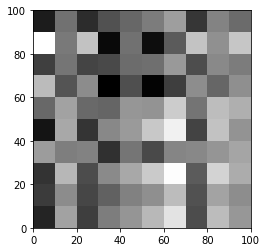

In [11]:
plt.imshow(a_new, cmap='gray', origin = 'lower',  extent = [0, 100, 0, 100],interpolation='nearest')

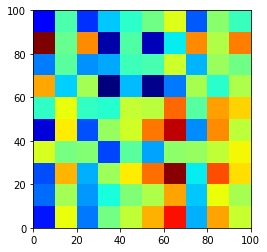

In [14]:
a = plt.imshow(a_new, cmap='jet', origin = 'lower',  extent = [0, 100, 0, 100],interpolation='nearest')
data = a.get_array()

Осталось сгенирировать достаточное число образцов. 

## Генерация датасета

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

Генерация

In [2]:
def generate_image(n, r):
    a=np.random.rand(n,n)
    (u,s,v)=np.linalg.svd(a)

    s_cut=np.zeros(n)
    s_cut[:r]=s[:r]

    s_mat=np.diag(s_cut)

    a_new=u.dot(s_mat).dot(v)
    
    image = a_new
    #image = cv2.resize(image, (100, 100), interpolation=cv2.INTER_NEAREST)
    image = np.uint8(255 * image)
    image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    return image

In [ ]:
N = 10000
file_size = 100
n = 10
threshold = 5

images = np.zeros((N*10, 10, 10, 3))
labels = np.zeros((N*10))
for i in range(N):
    for r in range(1, 11):
        image = generate_image(n, r)

        images[10*i+r-1] = image
        labels[10*i+r-1] = (r > threshold)

In [ ]:
N_test = 500
file_size = 100
n = 10

test_images = np.zeros((N_test*10, 10, 10, 3))
test_labels = np.zeros((N_test*10))
for i in range(N_test):
    for r in range(1, 11):
        image = generate_image(n, r)

        test_images[10*i+r-1] = image
        test_labels[10*i+r-1] = (r > threshold)

In [ ]:
images.shape

In [ ]:
test_images.shape

In [ ]:
labels[0:100]

Перемешивание

In [12]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [13]:
images, labels = unison_shuffled_copies(images, labels)
test_images, test_labels = unison_shuffled_copies(test_images, test_labels)

Сохранение

In [14]:
np.savez(
    "rank_1-5_and_6-10_classification_dataset.npz", 
    x_train=images, 
    y_train=labels,
    x_test=test_images,
    y_test=test_labels
)

## Обучение модели

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from tensorflow.keras.regularizers import l1_l2

D:\Users\maxim\Anaconda3\envs\maxim\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\maxim\Anaconda3\envs\maxim\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\maxim\Anaconda3\envs\maxim\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\maxim\Anaconda3\envs\maxim\lib\site-packages\tensorflow\python\f

Загрузка данных

In [2]:
with np.load("rank_1-5_and_6-10_classification_dataset.npz") as data:
    x_train = data["x_train"]
    y_train = data["y_train"]
    x_test = data["x_test"]
    y_test = data["y_test"]

Нормализация

In [3]:
x_train = keras.utils.normalize(x_train)
x_test = keras.utils.normalize(x_test)

Класс для аугментации данных

In [4]:
class MatixDataGenerator(keras.utils.Sequence):    
    def __init__(self, x_set, y_set, batch_size, shuffle=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        if self.shuffle:
            np.take(batch_x, np.random.permutation(batch_x.shape[1]), axis=1, out=batch_x)
            np.take(batch_x, np.random.permutation(batch_x.shape[2]), axis=2, out=batch_x)
            
        return np.array(batch_x), np.array(batch_y)

In [5]:
BATCH_SIZE = 128

xtrain_gen = MatixDataGenerator(x_train, y_train, batch_size=BATCH_SIZE)
xvalidation_gen = MatixDataGenerator(x_test, y_test, batch_size=BATCH_SIZE)

Создание модели

In [6]:
model_input = keras.layers.Input(shape=(10,10,3))

x = keras.layers.Conv2D(32, (3, 3), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(model_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.4)(x)

x = keras.layers.Conv2D(64, (3, 3), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.4)(x)

x = keras.layers.Conv2D(512, (3, 3), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.4)(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.4)(x)

x = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.models.Model(model_input, x)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 10, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 32)          896       
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 32)          128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Обучение

In [8]:
history = model.fit(
    xtrain_gen,
    epochs=50, 
    validation_data=xvalidation_gen
)

Epoch 1/50
40/40 [==============================] - 5s 134ms/step - loss: 1.4797 - acc: 0.7776 - val_loss: 2.7070 - val_acc: 0.5000
Epoch 2/50
40/40 [==============================] - 1s 22ms/step - loss: 1.1312 - acc: 0.8320 - val_loss: 2.3651 - val_acc: 0.5000
Epoch 3/50
40/40 [==============================] - 1s 21ms/step - loss: 1.0173 - acc: 0.8536 - val_loss: 2.0448 - val_acc: 0.5000
Epoch 4/50
40/40 [==============================] - 1s 22ms/step - loss: 0.9425 - acc: 0.8608 - val_loss: 1.9056 - val_acc: 0.5004
Epoch 5/50
40/40 [==============================] - 1s 22ms/step - loss: 0.8884 - acc: 0.8582 - val_loss: 1.7095 - val_acc: 0.5036
Epoch 6/50
40/40 [==============================] - 1s 22ms/step - loss: 0.8268 - acc: 0.8642 - val_loss: 1.5624 - val_acc: 0.5118
Epoch 7/50
40/40 [==============================] - 1s 22ms/step - loss: 0.7716 - acc: 0.8648 - val_loss: 1.2758 - val_acc: 0.5718
Epoch 8/50
40/40 [==============================] - 1s 23ms/step - loss: 0.7354 - 

In [9]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

5000/5000 - 0s - loss: 0.3839 - acc: 0.8908

Точность на проверочных данных: 0.8908


In [10]:
def show_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

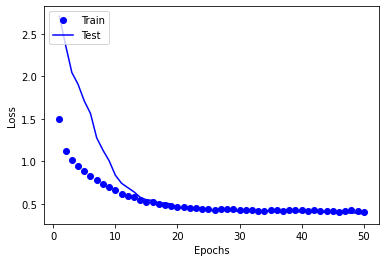

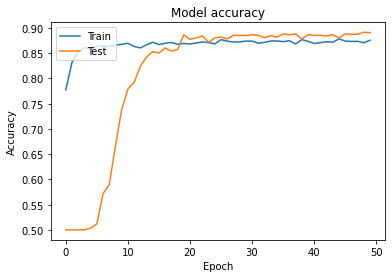

In [11]:
show_loss(history)

In [12]:
import itertools
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

In [13]:
y_pred = model.predict(x_test)
y_pred.shape

(5000, 1)

In [14]:
con_mat = metrics.confusion_matrix(y_test, (y_pred > 0.5))

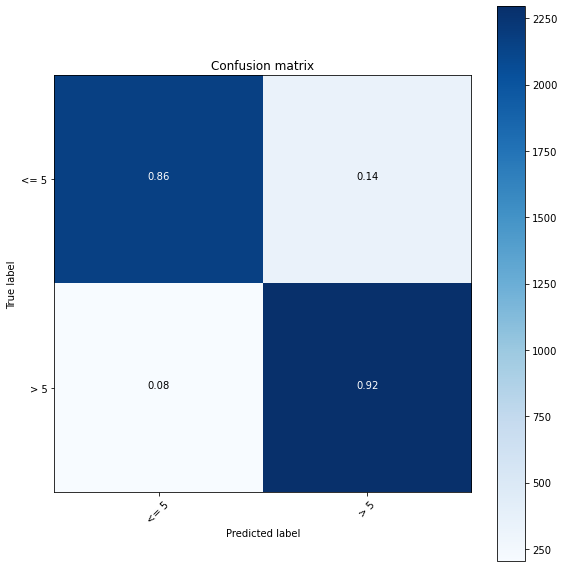

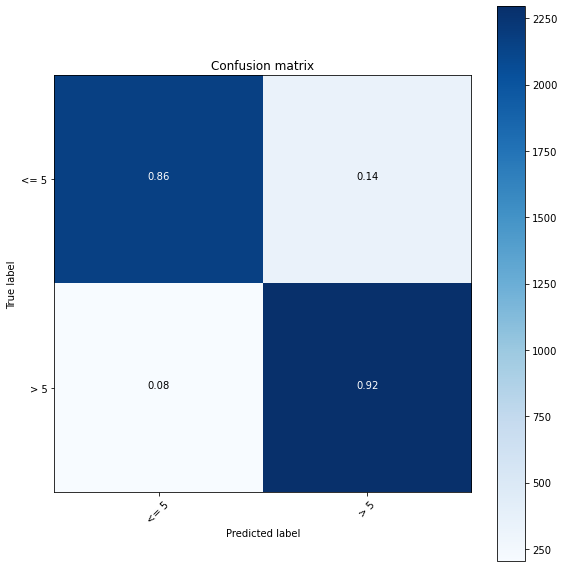

In [15]:
plot_confusion_matrix(con_mat, ['<= 5', '> 5'])